#The goal:
We have two data sets, one on feature charachteristics of specific individuals and the other on match outcomes of games played between said indiviuals. The goal of this exercise is to (1) build a model that can predict the outcome of an unplayed game based solely on the features of two players, especially players that are not represented in the train-test data set and, using the feature weights learnt, (2) build a ranking system of strength and recommender model that will pair a new player with the most similarly strengthed player.

Assume that the only data available is the "player_data.csv" and "match_data_classification.csv" moving forward. Thus, from this point onwards, we will not be able to access the match data functions. We will assume that these CSV files are our only way to access the truth of the world.

First we will explore our player data to understand how many players's data we have access to, the features that are present, and what these look like.

In [1]:
#Importing the required libraries
import pandas as pd
import seaborn as sns
import os
#Defining the location of the CSV
DIR = '/Users/mohamed.alzarai/Desktop/Git/badminton_lads/Data Files (CSV)'
file_path = os.path.join(DIR,'player_data.csv')
#Loading data into the data frame
player_data = pd.read_csv(file_path)
#Understanding the first few data points
display(player_data.head())
#The first column is not adding anything to our analysis as it acts as a counter, hence we can drop it
player_data.drop(player_data.columns[0], axis=1, inplace=True)
#Understanding the first few data points
display(player_data.head())

,Unnamed: 0,Name,Height,Weight,Age,Experience,Dominant_hand,Gender,Historic Win Ratio,Reaction Time,Play Frequency,Athleticism,Serve Speed,Court Coverage,Vision
0,0,A0,180,57,18,9,left,male,0.139547,161.497106,0.740670,5,111.738777,18.438436,20/20
1,1,A1,145,63,25,17,left,male,0.716022,520.794984,0.419526,4,121.785314,26.188609,20/20
2,2,A2,188,60,31,11,right,male,0.215322,558.096477,0.102219,4,111.934328,26.949887,20/60
3,3,A3,142,79,35,4,right,male,0.552045,597.642799,0.618524,7,117.232701,13.845772,20/20
4,4,A4,142,92,25,10,left,male,0.866485,328.075735,0.453416,7,117.296644,17.403619,20/40


,Name,Height,Weight,Age,Experience,Dominant_hand,Gender,Historic Win Ratio,Reaction Time,Play Frequency,Athleticism,Serve Speed,Court Coverage,Vision
0,A0,180,57,18,9,left,male,0.139547,161.497106,0.740670,5,111.738777,18.438436,20/20
1,A1,145,63,25,17,left,male,0.716022,520.794984,0.419526,4,121.785314,26.188609,20/20
2,A2,188,60,31,11,right,male,0.215322,558.096477,0.102219,4,111.934328,26.949887,20/60
3,A3,142,79,35,4,right,male,0.552045,597.642799,0.618524,7,117.232701,13.845772,20/20
4,A4,142,92,25,10,left,male,0.866485,328.075735,0.453416,7,117.296644,17.403619,20/40


We see that there are features, in particular the Dominant_Hand, Gender and Vision that are not numerical hence can not be used for calculatuons. We will look to convert these to numerical viua one-hot encoding (OHE).

For the DominantHand, we will return a column such that left(hand)=0 and right(hand)=1
For the Gender, we will reutrn a column such that female=0, and male=1
For the vision, we will evaluate the fraction i.e. 20/20=1, 20/60=0.33, 20/40=0.5

In [2]:
#Mapping values such that it is equiavalent to a OHE for dominant hand
player_data = pd.get_dummies(player_data, columns=['Dominant_hand'], drop_first=True)
#Mapping values such that it is equiavalent to a OHE for gender
player_data = pd.get_dummies(player_data, columns=['Gender'], drop_first=True)

#Converting both columns from booleans to binary for easier EDA and model building
player_data['Dominant_hand_right'] = player_data['Dominant_hand_right'].astype(int)
player_data['Gender_male'] = player_data['Gender_male'].astype(int)

#Evaluating the data in the vision column and coverting to real numbers/decimal representations
player_data['Vision']=player_data['Vision'].apply(lambda x: int(x.split('/')[0])/int(x.split('/')[1]))
display(player_data.head())


,Name,Height,Weight,Age,Experience,Historic Win Ratio,Reaction Time,Play Frequency,Athleticism,Serve Speed,Court Coverage,Vision,Dominant_hand_right,Gender_male
0,A0,180,57,18,9,0.139547,161.497106,0.740670,5,111.738777,18.438436,1.000000,0,1
1,A1,145,63,25,17,0.716022,520.794984,0.419526,4,121.785314,26.188609,1.000000,0,1
2,A2,188,60,31,11,0.215322,558.096477,0.102219,4,111.934328,26.949887,0.333333,1,1
3,A3,142,79,35,4,0.552045,597.642799,0.618524,7,117.232701,13.845772,1.000000,1,1
4,A4,142,92,25,10,0.866485,328.075735,0.453416,7,117.296644,17.403619,0.500000,0,1


Now, let us see the data held in the match data file. In particular, we will be looking to see which players win the most, and what features correlate the most to winning.

In [3]:
#Loading the data from the match data file
#Defining the location of the CSV
match_data_file_path = '/Users/mohamed.alzarai/Desktop/Git/badminton_lads/Data Files (CSV)/match_data_classification.csv'
match_data = pd.read_csv(match_data_file_path)
match_data.head()

,Player 1,Player 2,Win/Loss for Player 1
0,A0,A1,0
1,A0,A2,0
2,A0,A3,1
3,A0,A4,0
4,A0,A5,0


The furst thing I'm curious about is which player wins the most games. So lets find out.
Since the last column is essentially OHE to tell us about if Player 1 won or not, we just need to count the number of times Player 1 has a "1" in the last column

In [4]:
#Lets drop the second column because its not useful to us
match_data.drop(columns=['Player 2'],inplace=True)
#Creating a new array with what we want
match_data_summarised = match_data.groupby('Player 1').sum().reset_index()
display(match_data_summarised.head(5))



,Player 1,Win/Loss for Player 1
0,A0,52
1,A1,168
2,A2,90
3,A3,50
4,A4,121


In [5]:
#Let us add this new column into the player data set we already have
player_data_final = player_data
player_data_final['Total Matches Won'] = match_data_summarised['Win/Loss for Player 1']
display(player_data_final.head())
display(player_data)

,Name,Height,Weight,Age,Experience,Historic Win Ratio,Reaction Time,Play Frequency,Athleticism,Serve Speed,Court Coverage,Vision,Dominant_hand_right,Gender_male,Total Matches Won
0,A0,180,57,18,9,0.139547,161.497106,0.740670,5,111.738777,18.438436,1.000000,0,1,52
1,A1,145,63,25,17,0.716022,520.794984,0.419526,4,121.785314,26.188609,1.000000,0,1,168
2,A2,188,60,31,11,0.215322,558.096477,0.102219,4,111.934328,26.949887,0.333333,1,1,90
3,A3,142,79,35,4,0.552045,597.642799,0.618524,7,117.232701,13.845772,1.000000,1,1,50
4,A4,142,92,25,10,0.866485,328.075735,0.453416,7,117.296644,17.403619,0.500000,0,1,121


,Name,Height,Weight,Age,Experience,Historic Win Ratio,Reaction Time,Play Frequency,Athleticism,Serve Speed,Court Coverage,Vision,Dominant_hand_right,Gender_male,Total Matches Won
0,A0,180,57,18,9,0.139547,161.497106,0.740670,5,111.738777,18.438436,1.000000,0,1,52
1,A1,145,63,25,17,0.716022,520.794984,0.419526,4,121.785314,26.188609,1.000000,0,1,168
2,A2,188,60,31,11,0.215322,558.096477,0.102219,4,111.934328,26.949887,0.333333,1,1,90
3,A3,142,79,35,4,0.552045,597.642799,0.618524,7,117.232701,13.845772,1.000000,1,1,50
4,A4,142,92,25,10,0.866485,328.075735,0.453416,7,117.296644,17.403619,0.500000,0,1,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Z2,164,79,35,12,0.359651,629.687171,0.466009,7,129.626369,19.389808,0.333333,1,0,120
178,Z3,153,73,28,14,0.741255,109.731941,0.553316,5,121.582859,18.351561,0.500000,0,1,128
179,Z4,152,71,25,13,0.550647,666.078727,0.337571,7,126.431839,29.330165,0.250000,0,0,145
180,Z5,169,60,29,6,0.184056,633.618718,0.990324,1,120.478888,26.781370,1.000000,0,0,40


We will now create a new list of the players ranked by the number of matches won. This will help us have a visual view of which features are (roughly) the winning features. A summary of this table will also let us know how correct our prediction and recommendations are, by comparing to the relative ranking of the players.

In [6]:
#Creating a new list of players by ranking
ranked_players = player_data.sort_values(by=['Total Matches Won'],ascending=False)
#Viewing the features of the top set of players
display(ranked_players.head(15))
#Viewing the features of the bottom set of players
display(ranked_players.tail(15))

,Name,Height,Weight,Age,Experience,Historic Win Ratio,Reaction Time,Play Frequency,Athleticism,Serve Speed,Court Coverage,Vision,Dominant_hand_right,Gender_male,Total Matches Won
141,U1,143,68,30,20,0.962686,641.386496,0.813480,5,124.422569,13.796682,0.500000,1,1,181
172,Y4,180,93,31,18,0.972291,664.951846,0.671346,7,120.489261,23.926168,0.250000,1,1,180
22,D1,144,84,24,17,0.933260,628.518504,0.879271,3,115.699748,18.763691,0.333333,1,1,179
91,N0,144,58,26,20,0.994628,418.334102,0.453721,5,118.603987,25.861922,1.000000,1,0,178
89,M5,189,73,34,19,0.503844,667.249386,0.043375,7,128.175034,23.178061,0.333333,0,0,177
69,J6,162,71,35,18,0.932853,621.761010,0.980775,2,121.435953,14.671249,0.250000,1,0,176
132,S6,185,54,35,18,0.851364,527.085462,0.927325,6,113.481820,17.229844,0.500000,1,0,175
137,T4,172,91,23,19,0.658736,532.379661,0.605143,7,128.478595,10.823886,1.000000,0,1,174
165,X4,169,86,19,18,0.723283,337.569226,0.816455,6,114.358026,11.460591,0.250000,1,0,173
72,K2,181,55,28,18,0.626803,632.463210,0.487953,5,110.717982,11.368415,0.333333,1,0,172


,Name,Height,Weight,Age,Experience,Historic Win Ratio,Reaction Time,Play Frequency,Athleticism,Serve Speed,Court Coverage,Vision,Dominant_hand_right,Gender_male,Total Matches Won
64,J1,182,75,35,2,0.314524,293.964272,0.970185,4,127.298212,26.498544,1.000000,1,1,13
82,L5,177,74,29,4,0.025034,630.540907,0.561412,5,114.427344,11.264341,0.250000,0,0,13
97,N6,176,92,30,3,0.091767,418.289613,0.376201,4,116.817920,17.401062,0.333333,0,1,12
163,X2,188,65,37,3,0.078112,438.501233,0.061767,5,128.057763,14.043136,0.500000,1,0,12
71,K1,146,83,32,1,0.870934,681.974076,0.074837,7,129.384073,16.771225,0.250000,0,0,10
45,G3,189,91,19,1,0.839230,472.801394,0.238553,4,123.389177,21.279392,0.500000,0,1,9
100,O2,165,88,19,1,0.945325,560.409716,0.764163,3,116.562447,10.154598,0.250000,0,0,8
56,I0,156,80,21,3,0.074091,477.667424,0.053619,2,126.222842,28.982513,1.000000,1,0,7
155,W1,146,93,22,1,0.652896,628.388474,0.475705,6,113.989119,29.278281,0.333333,0,0,6
168,Y0,173,58,25,1,0.463009,531.456385,0.424134,4,126.467209,14.950241,0.333333,0,0,5


From the current data, we see that there is a clear demarcation of athletic ability (i.e. that an N ranked player will always beat a player ranked N+1 and always lose to a plyer ranked N-1). This isn't quite a surprise given that the data is synthetic. However, we now have a view of what features are most relevant to the most important target, namely the "Total Matches Won".

From this, it is quite difficult to guess which features are the most important to predicting the outcome of a winner. My guess is that Experience (positive correlation) is the most important, followed by Age (negative correlation) and Play Frequency.

However, we can get an exact measure of this through the correlation function.

<Axes: >

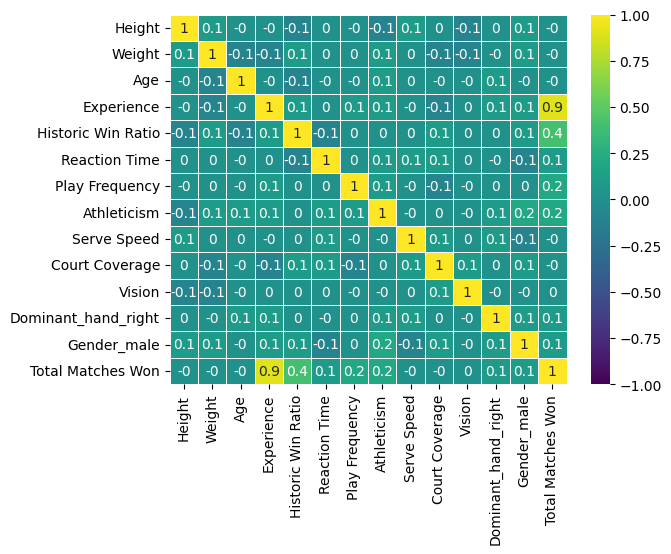

In [7]:
#Creating correlation matrix to discover relationship of numerical features against each other. 
ranking_correlation = ranked_players.corr(method='pearson',numeric_only=True).round(1)
#Showcasing as a heatmap
sns.heatmap(ranking_correlation,center=0,vmax=1,vmin=-1,annot=True,linewidths=0.5,cmap='viridis')

As expected, the Experience is the most correlated factor to winning. The others weren't as easy or obvious to spot. However, we can do better;

1. For feature selection and model building, we will find features that are (multi)collinear to select either the feature with the stronger correlation to the Total Matches Won or the feature that is domain-specific and easier to interpret (the latter might be useful to aid future decision making). Dropping correlated features will help reduce overfitting, speed up training and potentially deflate variance. We will opt against PCA because we would like to focus on interpretability. 

2. Once (1) is completed, we can rank the features relative to their impact on total matches won. This gives us an intuitive feeling of what to look out for to ensure our recommendor system is robust.

<Axes: >

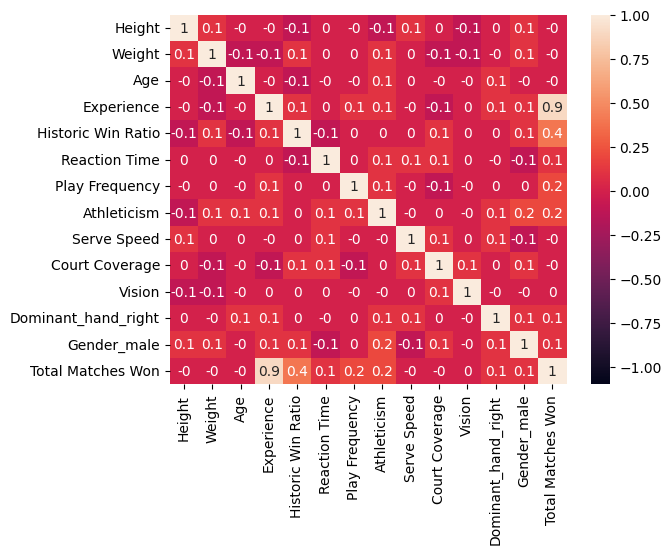

In [8]:
#Starting wtith multicollinear feature dropping (without accounting for total matches won)
#We are using the player data by itself
sns.heatmap(player_data.corr('pearson',numeric_only=True).round(1),vmax=-1,vmin=1,annot=True)